### Notebook Summary

#### Data Handling & Augmentation
- Uses MNIST dataset with custom wrapper class MNISTAlbumentations
- Implements Albumentations for transformations (Normalization)

#### Model Architecture (Model1)
- Each block contains:
  - Two 3x3 convolutions with padding=1
  - BatchNormalization after each conv
  - LeakyReLU activation
  - MaxPooling (2x2)
  - Global Average Pooling instead of fully connected layers
- Total params: 6,984 (very lightweight)


#### Training Configuration
- Batch size: 512
- Optimizer: SGD with momentum and constant learning rate
- Number of epochs: 15
- Device: Uses MPS/CUDA if available, else CPU

#### **Target: 99%+ test accuracy**
Result: Achieved 99.02% best test accuracy
Analysis:

#### 1. Target Justification:
- MNIST is considered a relatively simple dataset
- State-of-the-art models achieve >99% accuracy
- The chosen architecture has sufficient capacity (6,984 parameters)
- Previous implementations show 99% is achievable with similar architectures

#### 2. Architecture Analysis:
- Progressive channel increase (8→12→16) allows gradual feature extraction
- Dual convolutions per block enable complex feature learning
- BatchNorm helps with internal covariate shift and training stability
- LeakyReLU prevents dying ReLU problem
- Global Average Pooling reduces parameters and prevents overfitting

#### 3. Results Analysis:
- Training accuracy reached 99.37% (slight overfitting)
- Test accuracy peaked at 99.02% (met target)
- Fast convergence (>98% by epoch 4)
- Consistent performance in later epochs
- Small gap between train/test accuracy indicates good generalization

#### 4. Potential Improvements:
- Add dropout for better regularization
- Implement learning rate scheduling
- Experiment with data augmentation techniques
- Try different optimizers like Adam
- Try image augmentation 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import Model1 as Net
from utils import visualize_augmentations
from train import train, test


#### Device Configuration

In [2]:

use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")


#### Custom Dataset

In [3]:
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


###################
# Data Augmentation
###################

# Training augmentation pipeline
train_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Test transforms (only normalization)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])


In [4]:
# Initial setup
torch.manual_seed(14596)

# Training parameters
batch_size = 512
kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}

# Initialize model and print summary
model = Net(0.01).to(device)
print(summary(model, input_size=(1, 1, 28, 28), device=device))


Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 16]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            72
│    └─BatchNorm2d: 2-2                  [1, 8, 28, 28]            16
│    └─LeakyReLU: 2-3                    [1, 8, 28, 28]            --
│    └─Dropout: 2-4                      [1, 8, 28, 28]            --
│    └─Conv2d: 2-5                       [1, 8, 28, 28]            576
│    └─BatchNorm2d: 2-6                  [1, 8, 28, 28]            16
│    └─LeakyReLU: 2-7                    [1, 8, 28, 28]            --
│    └─MaxPool2d: 2-8                    [1, 8, 14, 14]            --
│    └─Dropout: 2-9                      [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 12, 7, 7]             --
│    └─Conv2d: 2-10                      [1, 12, 14, 14]           864
│    └─BatchN

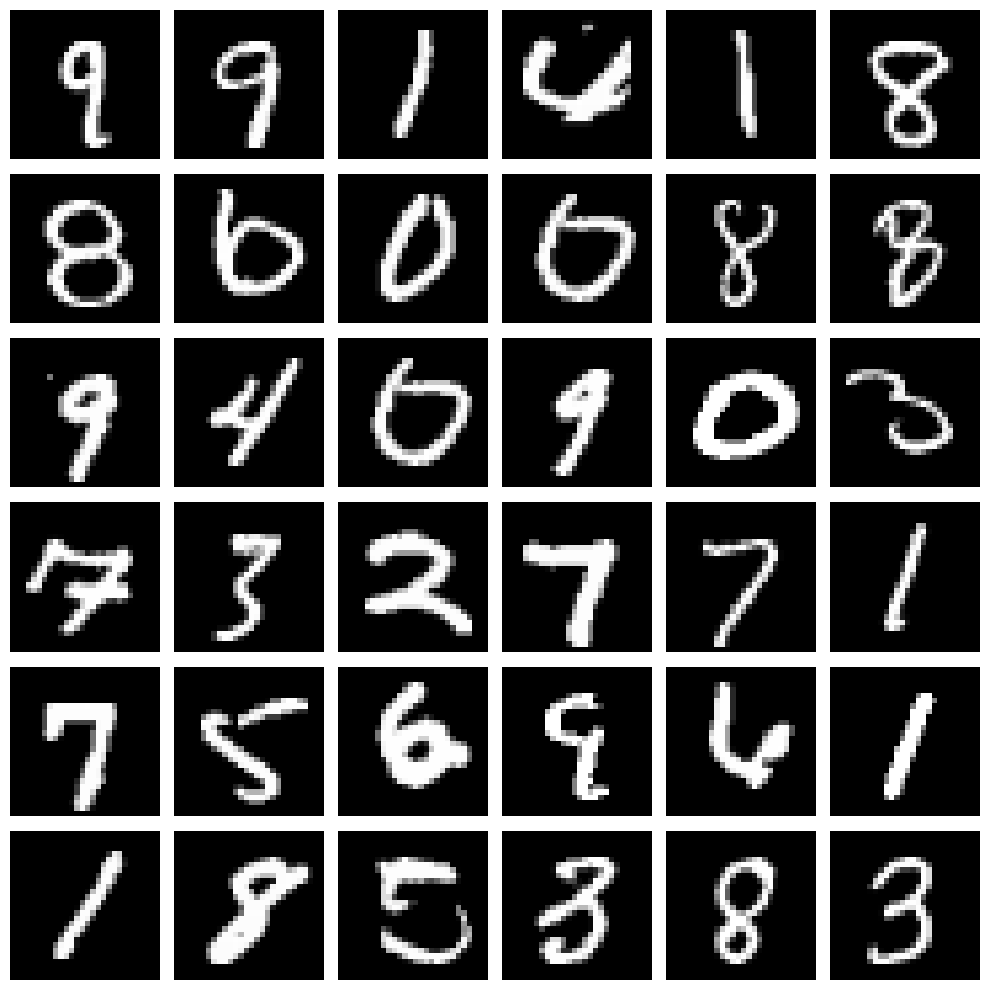

In [5]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

visualize_augmentations(train_loader.dataset)

In [6]:
lr = 0.01
momentum = 0.95
weight_decay = 0.0005
drop_out = 0.0

num_epochs = 15
# Initialize model and optimizer
model = Net(drop_out).to(device)
optimizer = optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
)

# Training Loop
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)
    best_accuracy = max(best_accuracy, accuracy)

print(f"\nBest accuracy achieved: {best_accuracy:.2f}%")


Epoch 1/15
Learning rate: 0.010000


Training set: loss=0.24719 accuracy=83.50% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 44.79it/s]


Test set: Average loss: 0.18392, Accuracy: 9612/10000 (96.12%)

Epoch 2/15
Learning rate: 0.010000


Training set: loss=0.08617 accuracy=97.39% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.41it/s]


Test set: Average loss: 0.10497, Accuracy: 9760/10000 (97.60%)

Epoch 3/15
Learning rate: 0.010000


Training set: loss=0.10340 accuracy=98.19% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 50.80it/s]


Test set: Average loss: 0.08918, Accuracy: 9812/10000 (98.12%)

Epoch 4/15
Learning rate: 0.010000


Training set: loss=0.05036 accuracy=98.48% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 50.31it/s]


Test set: Average loss: 0.07030, Accuracy: 9830/10000 (98.30%)

Epoch 5/15
Learning rate: 0.010000


Training set: loss=0.04159 accuracy=98.73% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.13it/s]


Test set: Average loss: 0.05466, Accuracy: 9865/10000 (98.65%)

Epoch 6/15
Learning rate: 0.010000


Training set: loss=0.08799 accuracy=98.83% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.32it/s]


Test set: Average loss: 0.06200, Accuracy: 9858/10000 (98.58%)

Epoch 7/15
Learning rate: 0.010000


Training set: loss=0.02966 accuracy=98.88% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 50.79it/s]


Test set: Average loss: 0.05443, Accuracy: 9847/10000 (98.47%)

Epoch 8/15
Learning rate: 0.010000


Training set: loss=0.05704 accuracy=99.06% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 50.92it/s]


Test set: Average loss: 0.04740, Accuracy: 9882/10000 (98.82%)

Epoch 9/15
Learning rate: 0.010000


Training set: loss=0.02565 accuracy=99.08% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.44it/s]


Test set: Average loss: 0.05279, Accuracy: 9868/10000 (98.68%)

Epoch 10/15
Learning rate: 0.010000


Training set: loss=0.07140 accuracy=99.17% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.24it/s]


Test set: Average loss: 0.03869, Accuracy: 9902/10000 (99.02%)

Epoch 11/15
Learning rate: 0.010000


Training set: loss=0.02578 accuracy=99.21% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.81it/s]


Test set: Average loss: 0.05534, Accuracy: 9829/10000 (98.29%)

Epoch 12/15
Learning rate: 0.010000


Training set: loss=0.07728 accuracy=99.23% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.92it/s]


Test set: Average loss: 0.04201, Accuracy: 9896/10000 (98.96%)

Epoch 13/15
Learning rate: 0.010000


Training set: loss=0.02258 accuracy=99.31% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.21it/s]


Test set: Average loss: 0.03989, Accuracy: 9895/10000 (98.95%)

Epoch 14/15
Learning rate: 0.010000


Training set: loss=0.03882 accuracy=99.36% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 50.99it/s]


Test set: Average loss: 0.03955, Accuracy: 9894/10000 (98.94%)

Epoch 15/15
Learning rate: 0.010000


Training set: loss=0.06030 accuracy=99.37% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.15it/s]


Test set: Average loss: 0.03836, Accuracy: 9890/10000 (98.90%)


Best accuracy achieved: 99.02%
